# "Standing on the shoulders of giants"

Python notebook with the source code used in the methodology of the paper submitted to BRACIS'24.

It is recommended to run this notebook using Google Colab.

Notebook designed to run in order.

## Install and Import packages

In [ ]:
!pip install openml
!pip install rpy2
!pip install catsim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.9 MB/s eta 0:00:00
  Created wheel for openml: filename=openml-0.14.2-py3-none-any.whl size=158700 sha256=928b042e147c723ac993660be2c7e2b8a25cebfeba84458b7f2ddb7833d89256
  Stored in directory: /root/.cache/pip/wheels/2e/4e/af/5e721761d86375dbca82e63cc2470019e97815bc39f11451ea
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=abaee499168ebf4950e99e77fc1ba01ecb69932e16b0ab79e3d4ebf8b951ef3a
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built openml liac-arff
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.rinterface import RRuntimeWarning
import warnings
warnings.filterwarnings("ignore", category=RRuntimeWarning)

utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

if not rpackages.isinstalled('ltm'):
    print('Pacote ltm nao instalado. Instalando...')
    utils.install_packages('ltm')

#Importa o pacore ltm do R
ltm = rpackages.importr('ltm')
pandas2ri.activate()

(as ‘lib’ is unspecified)



Pacote ltm nao instalado. Instalando...



































	‘/tmp/RtmpCwBj24/downloaded_packages’



In [ ]:
import random
import numpy as np
import pandas as pd
import copy

import os
import openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import matthews_corrcoef, auc, roc_curve, confusion_matrix
from sklearn.metrics import classification_report

from catsim.estimation import NumericalSearchEstimator
from catsim.irt import icc_hpc
from catsim.irt import icc, inf

from scipy.interpolate import make_interp_spline
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Defines the classes and functions used in the methodology

### Defines the model pool classes of 10 different classification algorithms

In [ ]:
class RF():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = None

    if seed == None:
      self.seed = 42
      self.clf = RandomForestClassifier(random_state = 42)
      self.name = 'RF_std'
    else:
      self.name = 'RF_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'RF_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    n_estimators = random.randint(1,100)
    criterion = random.choice(['gini','entropy','log_loss'])
    max_features = random.choice(['sqrt','log2',None])
    random_state = self.seed

    random.seed(None)

    return n_estimators, criterion, max_features, random_state

  def random_clf(self):
    n_estimators, criterion, max_features, random_state = self.choice_random_param()

    return RandomForestClassifier(n_estimators = n_estimators,
                                  criterion = criterion,
                                  max_features = max_features,
                                  random_state = random_state)

class GB():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = 'GB_'+str(seed)

    if seed == None:
      self.seed = 42
      self.clf = GradientBoostingClassifier(random_state = 42)
      self.name = 'GB_std'
    else:
      self.name = 'GB_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'GB_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    n_estimators = random.randint(1,100)
    criterion = random.choice(['friedman_mse','squared_error'])
    max_features = random.choice(['sqrt','log2',None])
    random_state = self.seed

    random.seed(None)

    return n_estimators, criterion, max_features, random_state

  def random_clf(self):
    n_estimators, criterion, max_features, random_state = self.choice_random_param()

    return GradientBoostingClassifier(n_estimators = n_estimators,
                                      criterion = criterion,
                                      max_features = max_features,
                                      random_state = random_state)

class BAG():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = 'BAG_'+str(seed)

    if seed == None:
      self.seed = 42
      self.clf = BaggingClassifier(random_state = 42)
      self.name = 'BAG_std'
    else:
      self.name = 'BAG_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'BAG_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    n_estimators = random.randint(1,100)
    bootstrap = random.choice([True,False])
    random_state = self.seed

    random.seed(None)

    return n_estimators, bootstrap, random_state

  def random_clf(self):
    n_estimators, bootstrap, random_state = self.choice_random_param()

    return BaggingClassifier(n_estimators = n_estimators,
                             bootstrap = bootstrap,
                             random_state = random_state)

class ADA():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = 'ADA_'+str(seed)

    if seed == None:
      self.seed = 42
      self.clf = AdaBoostClassifier(algorithm='SAMME',random_state = 42)
      self.name = 'ADA_std'
    else:
      self.name = 'ADA_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'ADA_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    n_estimators = random.randint(1,100)
    random_state = self.seed

    random.seed(None)

    return n_estimators, random_state

  def random_clf(self):
    n_estimators, random_state = self.choice_random_param()

    return AdaBoostClassifier(n_estimators = n_estimators,
                              algorithm='SAMME',
                              random_state = random_state)

class MLP():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = 'MLP_'+str(seed)

    if seed == None:
      self.seed = 42
      self.clf = MLPClassifier(random_state = 42)
      self.name = 'MLP_std'
    else:
      self.name = 'MLP_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'MLP_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    max_iter = random.randint(1,200)
    activation = random.choice(['identity','logistic','tanh','relu'])
    solver = random.choice(['lbfgs','sgd','adam'])
    random_state = self.seed

    random.seed(None)

    return max_iter, activation, solver, random_state

  def random_clf(self):
    max_iter, activation, solver, random_state = self.choice_random_param()

    return MLPClassifier(max_iter = max_iter,
                         activation = activation,
                         solver = solver,
                         random_state = random_state)

class DT():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = 'DT_'+str(seed)

    if seed == None:
      self.seed = 42
      self.clf = DecisionTreeClassifier(random_state = 42)
      self.name = 'DT_std'
    else:
      self.name = 'DT_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'DT_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    criterion = random.choice(['gini','entropy','log_loss'])
    splitter = random.choice(['best','random'])
    max_features = random.choice(['sqrt','log2',None])
    random_state = self.seed

    random.seed(None)

    return criterion, splitter, max_features, random_state

  def random_clf(self):
    criterion, splitter, max_features, random_state = self.choice_random_param()

    return DecisionTreeClassifier(criterion = criterion,
                                  splitter= splitter,
                                  max_features = max_features,
                                  random_state = random_state)

class KNN():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = 'KNN_'+str(seed)

    if seed == None:
      self.seed = 42
      self.clf = KNeighborsClassifier()
      self.name = 'KNN_std'
    else:
      self.name = 'KNN_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'KNN_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    n_neighbors = random.randint(1,15)
    if (n_neighbors % 2) == 0: # seleciona apenas numeros impares
      n_neighbors += 1

    weights = random.choice(['uniform','distance'])
    algorithm = random.choice(['auto','ball_tree','kd_tree','brute'])

    random.seed(None)

    return n_neighbors, weights, algorithm

  def random_clf(self):
    n_neighbors, weights, algorithm = self.choice_random_param()

    return KNeighborsClassifier(n_neighbors = n_neighbors,
                                weights = weights,
                                algorithm = algorithm)

class SVM():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = 'SVM_'+str(seed)

    if seed == None:
      self.seed = 42
      self.clf = SVC(random_state = 42)
      self.name = 'SVM_std'
    else:
      self.name = 'SVM_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'SVM_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    kernel = random.choice(['linear','rbf','sigmoid'])
    gamma = random.choice(['auto','scale'])
    random_state = self.seed

    random.seed(None)

    return kernel, gamma, random_state

  def random_clf(self):
    kernel, gamma, random_state = self.choice_random_param()

    return SVC(kernel = kernel,
               gamma = gamma,
               random_state = random_state)

class LSVM():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = 'LSVM_'+str(seed)

    if seed == None:
      self.seed = 42
      self.clf = LinearSVC(random_state = 42)
      self.name = 'LSVM_std'
    else:
      self.name = 'LSVM_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'LSVM_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    loss = random.choice(['hinge','squared_hinge'])
    max_iter = random.randint(800,1000)
    random_state = self.seed

    random.seed(None)

    return loss, max_iter, random_state

  def random_clf(self):
    loss, max_iter, random_state = self.choice_random_param()

    return LinearSVC(loss = loss,
                     max_iter = max_iter,
                     random_state = random_state)

class LDA():
  def __init__(self, seed = None):
    self.seed = None
    self.clf = None
    self.name = 'LDA_'+str(seed)

    if seed == None:
      self.seed = 42
      self.clf = LinearDiscriminantAnalysis()
      self.name = 'LDA_std'
    else:
      self.name = 'LDA_'+str(seed)

  def set_seed(self, seed):
    self.seed = seed
    self.clf = self.random_clf()
    self.name = 'LDA_'+str(seed)

  def choice_random_param(self):
    random.seed(self.seed)

    solver = random.choice(['svd','lsqr'])
    if (solver == 'lsqr'):
      shrinkage = random.choice(['auto',None])
    else:
      shrinkage = None

    random.seed(None)

    return solver, shrinkage

  def random_clf(self):
    solver, shrinkage = self.choice_random_param()

    return LinearDiscriminantAnalysis(solver = solver,
                                      shrinkage = shrinkage)

In [ ]:
class modelsPool():
  def __init__(self, clf_type, n_models = 10):
    clf_dict = {'RF':RF(),'GB':GB(),'BAG':BAG(),'ADA':ADA(),'KNN':KNN(),'DT':DT(),'SVM':SVM(),'MLP':MLP(),'LDA':LDA(),'LSVM':LSVM()}

    self.vector = []
    for i in range(0,n_models):
      model_tmp = clf_dict[clf_type]
      model_tmp.set_seed(i)
      self.vector.append(copy.deepcopy(model_tmp))

### Data processing functions

In [ ]:
#one hot encoding using OneHotEncoder of Scikit-Learn
def OneHotencodeData(data):

  categorical_columns = [i for i in data.columns if data[i].dtype.name == 'category']

  encoder = OneHotEncoder(sparse_output=False)

  one_hot_encoded = encoder.fit_transform(data[categorical_columns])

  one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

  df_encoded = pd.concat([data, one_hot_df], axis=1)

  df_encoded = df_encoded.drop(categorical_columns, axis=1)

  return df_encoded

### Machine Learning aux functions

In [ ]:
def compare_resp(original, pred):

    tmp = []
    for i in range(len(original)):
        if original[i] == pred[i]:
            tmp.append(1)
        else:
            tmp.append(0)
    return tmp

In [ ]:
def calc_ML_metrics(pred_clf,y_test):

  dict_metrics = {}

  for clf in pred_clf:
    clf_acc = accuracy_score(y_test,pred_clf[clf])
    clf_f1 = f1_score(y_test,pred_clf[clf])
    clf_precision = precision_score(y_test,pred_clf[clf])
    clf_recall = recall_score(y_test,pred_clf[clf])
    fpr, tpr, threshoulds = roc_curve(y_test,pred_clf[clf])
    clf_auc = auc(fpr,tpr)
    tn, fp, fn, tp = confusion_matrix(y_test,pred_clf[clf]).ravel()
    clf_spe = tn / (tn+fp)


    dict_metrics[clf] = {'acc_score':clf_acc,
                          'f1_score':clf_f1,
                          'precision_score':clf_precision,
                          'recall_score':clf_recall,
                          'auc_score':clf_auc,
                          'specf_score':clf_spe}

  return dict_metrics

In [ ]:
def list_confusion_matrix(y_test,y_pred):
  tp = []
  tn = []
  fp = []
  fn = []

  for inst_i in range(len(y_test)):
    if y_pred[inst_i] == 1:
      if y_pred[inst_i] == y_test[inst_i]:
        tp.append(inst_i)

      elif y_pred[inst_i] != y_test[inst_i]:
        fp.append(inst_i)
    else:
      if y_pred[inst_i] == y_test[inst_i]:
        tn.append(inst_i)

      elif y_pred[inst_i] != y_test[inst_i]:
        fn.append(inst_i)

  return tp, fp, tn, fn

### IRT functions

In [ ]:
def calcIRT(respMatrix):

  pd.DataFrame.iteritems = pd.DataFrame.items

  data = ltm.tpm(respMatrix)

  par = str(data).split('\n')

  irt_param_matrix = []
  key = 0
  for c,string in enumerate(par):
    if string == 'Coefficients:':
      key= 1
    if key:
      str_list = string.split()
      if str_list == []:
        break
      elif len(str_list) == 4:
        dis = float(str_list[3])
        dif = float(str_list[2])
        gues = float(str_list[1])
        irt_param_matrix.append([dis,dif,gues])

  irt_df = pd.DataFrame(irt_param_matrix, columns=['Dis','Dif','Gues'])
  return irt_df

In [ ]:
def calc_irt_totalScore(resp_vector,prob_correct_vector,dis_vector=None):

  totalScore = 0
  for c,resp_i in enumerate(resp_vector):
    prob_corret_value = prob_correct_vector[c]
    if resp_i == 1:
      totalScore += prob_corret_value
    else:
      if dis_vector != None:
        if dis_vector[c] > 0:
          prob_corret_value = 1 - prob_corret_value
      else:
        prob_corret_value = 1 - prob_corret_value
      totalScore -= prob_corret_value

  return totalScore

In [ ]:
def plot_icc(irt_parameters_matrix,cm_instances,model_name,output_dataset,dict_probCorrect,dict_totalScore):

  lista_ax = [[0,0],[0,1],[1,1],[1,0]]

  cm_list = ['True Positive','False Positive','True Negative','False Negative']

  cm_dict = {'tp':0, 'fp':1, 'tn':2, 'fn':3}

  fig, axs = plt.subplots(2, 2, figsize=(12, 8))

  for ci,instance_type in enumerate(cm_dict):

    irt_matrix_tmp = np.array([irt_parameters_matrix[i] for i in cm_instances[cm_dict[instance_type]]])

    i = lista_ax[ci][0]
    j = lista_ax[ci][1]

    x = [p for p in np.linspace(-3,3,500)]
    for irt_param in irt_matrix_tmp:

      a = irt_param[0]
      b = irt_param[1]
      c = irt_param[2]
      d = irt_param[3]

      lista1 = [icc(theta=t,a=a,b=b,c=c,d=d) for t in x]

      model=make_interp_spline(x, lista1)

      xs=np.linspace(-3,3,500)
      ys=model(xs)

      if lista1[-1] > lista1[0]:
        axs[i,j].plot(xs, ys,color='b',alpha=0.3,linewidth=0.9)
      else:
        axs[i,j].plot(xs, ys,color='red',alpha=0.3,linewidth=0.9)

    a = [p[0] for p in irt_matrix_tmp]
    b = [p[1] for p in irt_matrix_tmp]
    c = [p[2] for p in irt_matrix_tmp]

    lista1 = [icc(theta=t,a=np.mean(a),b=np.mean(b),c=np.mean(c),d=1) for t in x]
    inf_list = [inf(theta=t,a=np.mean(a),b=np.mean(b),c=np.mean(c),d=1) for t in x]

    model=make_interp_spline(x, lista1)

    xs=np.linspace(-3,3,500)
    ys=model(xs)

    prob_correct = sum(dict_probCorrect[model_name][instance_type])
    prob_perc = (100*prob_correct)/len(a)

    axs[i,j].plot(xs, ys,color='black', label="a = {:.3f}\nb = {:.3f}\nc = {:.3f}\ntotalS = {:.3f}\ninf = {:.3f}\nn = {}".format(np.mean(a),np.mean(b),np.mean(c),
                                                                                                                                     #prob_correct,
                                                                                                                                     dict_totalScore[model_name][instance_type],
                                                                                                                                     np.mean(inf_list),
                                                                                                                                     len(a)))
    axs[i,j].set_title(cm_list[ci])
    axs[i,j].title.set_size(18)

    axs[i,j].plot((0, 0), (0, 1),color='grey', linestyle='dashed',linewidth=0.8)
    axs[i,j].plot((-3, 3), (0.5, 0.5),color='grey', linestyle='dashed',linewidth=0.8)

    leg = axs[i,j].legend(loc='upper right', shadow=False,markerscale=0,handlelength=0, handletextpad=0, fancybox=True, fontsize=14)
    for item in leg.legendHandles:
      item.set_visible(False)


    for ax in axs.flat:
      ax.set_xlabel('Ability', fontsize = 18)
      ax.set_ylabel('Prob. Correct', fontsize = 18)

    for ax in axs.flat:
      ax.label_outer()

    fig.suptitle(model_name+' Item Characteristic Curve', size = 20)

    fig.tight_layout()

    fig.savefig(output_dataset+'/figures/'+model_name+'.png', bbox_inches="tight",dpi=300)

## Get the heart-statlog dataset

In [ ]:
# Obtem dataset do openml

openml.config.cache_directory = os.path.expanduser(os.getcwd()+'/cache')

data_set_id = 53 #heart-statlog
dataset = openml.datasets.get_dataset(data_set_id)
name_dataset = dataset.name

X, y, categorical_indicator, attribute_names = dataset.get_data(dataset_format='dataframe',
                                                                target=dataset.default_target_attribute)

X = OneHotencodeData(X)

le = LabelEncoder()
le.fit(y)
y = le.transform(y)

# 1 = presente
# 0 = ausente

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,random_state=0,shuffle=True,test_size=0.3)

In [ ]:
X

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal
0,70,1,4,130,322.0,0,2,109,0,2.4,2,3,3
1,67,0,3,115,564.0,0,2,160,0,1.6,2,0,7
2,57,1,2,124,261.0,0,0,141,0,0.3,1,0,7
3,64,1,4,128,263.0,0,0,105,1,0.2,2,1,7
4,74,0,2,120,269.0,0,2,121,1,0.2,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,172,199.0,1,0,162,0,0.5,1,0,7
266,44,1,2,120,263.0,0,0,173,0,0.0,1,0,7
267,56,0,2,140,294.0,0,2,153,0,1.3,2,0,3
268,57,1,4,140,192.0,0,0,148,0,0.4,2,0,6


### Saves training and testing datasets

In [ ]:
output_dir = 'output'
output_dataset = output_dir+'/'+name_dataset

if not os.path.exists(output_dataset):
    os.makedirs(output_dataset)

# Save full dataset
dataset_tmp = copy.deepcopy(X)
dataset_tmp['class'] = y
dataset_tmp.to_csv(output_dataset+'/'+name_dataset+'.csv', index=False)

# Save train dataset
dataset_tmp = copy.deepcopy(X_train)
dataset_tmp['class'] = y_train
dataset_tmp.to_csv(output_dataset+'/'+name_dataset+'_train.csv', index=False)

# Save test dataset
dataset_tmp = copy.deepcopy(X_test)
dataset_tmp['class'] = y_test
dataset_tmp.to_csv(output_dataset+'/'+name_dataset+'_test.csv', index=False)

## Generates 200 random models

In [ ]:
list_of_clfs_type = ['RF','GB','BAG','ADA','KNN','DT','SVM','MLP','LDA','LSVM']

pool_of_random_models = []

for clf_type in list_of_clfs_type:
  list_of_model = modelsPool(clf_type=clf_type,n_models=20)

  for model_i in list_of_model.vector:
    pool_of_random_models.append(model_i)

In [ ]:
dict_pred_random = {}
dict_resp_random = {}

for model_i in pool_of_random_models:
  #print(model_i.name)
  #print(model_i.clf)
  model_i.clf.fit(X_train, y_train)
  y_pred = model_i.clf.predict(X_test)
  dict_pred_random[model_i.name] = y_pred
  dict_resp_random[model_i.name] = compare_resp(y_test, y_pred)
  #print(accuracy_score(y_test, y_pred))

### Saves the response of random classifiers

In [ ]:
output_dir = 'output'
output_dataset = output_dir+'/'+name_dataset

if not os.path.exists(output_dataset):
    os.makedirs(output_dataset)

df = pd.DataFrame(dict_pred_random).transpose()
df.to_csv(output_dataset+'/random_models_prediction_matrix.csv')

df = pd.DataFrame(dict_resp_random).transpose()
#df.rename(columns={i:'V'+str(i+1) for i in range(len(df.columns))}, inplace=True)
df.to_csv(output_dataset+'/random_models_response_matrix.csv')#,index=False)

## Generates 10 fine-tuned models with grid search

### Defines the models and hyperparameters that will be combined by the grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

dict_param_models = {
    'RF': {'n_estimators':[i for i in range(1,101)],
           'criterion': ['gini','entropy','log_loss'],
           'max_features': ['sqrt','log2',None]},
    'GB': {'n_estimators':[i for i in range(1,101)],
           'criterion': ['friedman_mse','squared_error'],
           'max_features': ['sqrt','log2',None]},
    'BAG': {'n_estimators':[i for i in range(1,101)],
           'bootstrap': [True,False]},
    'ADA': {'n_estimators':[i for i in range(1,101)]},
    'MLP': {'max_iter':[i for i in range(1,201)],
           'activation': ['identity','logistic','tanh','relu'],
           'solver': ['lbfgs','sgd','adam']},
    'DT': {'splitter':['best','random'],
           'criterion': ['gini','entropy','log_loss'],
           'max_features': ['sqrt','log2',None]},
    'KNN': {'n_neighbors':[3,5,7,9,11,13,15],
           'weights': ['uniform','distance'],
           'algorithm': ['auto','ball_tree','kd_tree','brute']},
    'SVM': {'kernel':['linear','rbf','sigmoid'],
           'gamma': ['auto','scale']},
    'LSVM': {'loss':['hinge','squared_hinge'],
           'max_iter': [i for i in range(800,1001)]},
    'LDA': {'solver':['svd','lsqr'],
           'shrinkage': ['auto',None]},
}

clf_dict = {'RF':RandomForestClassifier(random_state=42),
            'GB':GradientBoostingClassifier(random_state = 42),
            'BAG':BaggingClassifier(random_state = 42),
            'ADA':AdaBoostClassifier(random_state = 42),
            'KNN':KNeighborsClassifier(),
            'DT':DecisionTreeClassifier(random_state = 42),
            'SVM':SVC(random_state = 42),
            'MLP':MLPClassifier(random_state = 42),
            'LDA':LinearDiscriminantAnalysis(),
            'LSVM':LinearSVC(random_state = 42)}


In [ ]:
pool_of_final_models = {}
for clf in clf_dict:
  print('Grid Search para {}'.format(clf))
  pool_of_final_models[clf] = GridSearchCV(clf_dict[clf], dict_param_models[clf])
  pool_of_final_models[clf].fit(X_train, y_train)

Grid Search para RF
Grid Search para GB
Grid Search para BAG
Grid Search para ADA
Grid Search para KNN
Grid Search para DT
Grid Search para SVM
Grid Search para MLP
Grid Search para LDA
Grid Search para LSVM


In [ ]:
for clf in pool_of_final_models:
  print("\'{}\':{},".format(clf,pool_of_final_models[clf].best_estimator_))

'RF':RandomForestClassifier(criterion='entropy', n_estimators=93, random_state=42),
'GB':GradientBoostingClassifier(max_features='sqrt', n_estimators=9, random_state=42),
'BAG':BaggingClassifier(n_estimators=41, random_state=42),
'ADA':AdaBoostClassifier(n_estimators=7, random_state=42),
'KNN':KNeighborsClassifier(n_neighbors=15),
'DT':DecisionTreeClassifier(random_state=42),
'SVM':SVC(gamma='auto', kernel='linear', random_state=42),
'MLP':MLPClassifier(activation='identity', max_iter=103, random_state=42,
              solver='lbfgs'),
'LDA':LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'),
'LSVM':LinearSVC(max_iter=807, random_state=42),


### List of models with hyperparameters defined by grid search

This same list of templates can be obtained by running the previous set of cells. As this is a more time-consuming step, the final list of models was saved here.

In [ ]:
pool_of_best_models = {'RF':RandomForestClassifier(criterion='entropy', n_estimators=93, random_state=42),
'GB':GradientBoostingClassifier(max_features='sqrt', n_estimators=9, random_state=42),
'BAG':BaggingClassifier(n_estimators=41, random_state=42),
'ADA':AdaBoostClassifier(n_estimators=7, random_state=42),
'KNN':KNeighborsClassifier(n_neighbors=15),
'DT':DecisionTreeClassifier(random_state=42),
'SVM':SVC(gamma='auto', kernel='linear', random_state=42),
'MLP':MLPClassifier(activation='identity', max_iter=103, random_state=42,
              solver='lbfgs'),
'LDA':LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'),
'LSVM':LinearSVC(max_iter=807, random_state=42)}

In [ ]:
dict_pred_final = {}
dict_resp_final = {}

for model_i in pool_of_best_models:
  #print(model_i.name)
  print(model_i)
  pool_of_best_models[model_i].fit(X_train, y_train)
  y_pred = pool_of_best_models[model_i].predict(X_test)
  dict_pred_final[model_i] = y_pred
  dict_resp_final[model_i] = compare_resp(y_test, y_pred)
  #print(accuracy_score(y_test, y_pred))

RF
GB
BAG
ADA
KNN
DT
SVM
MLP
LDA
LSVM


### Saves the response of fine-tuning models

In [ ]:
output_dir = 'output'
output_dataset = output_dir+'/'+name_dataset

if not os.path.exists(output_dataset):
    os.makedirs(output_dataset)

df = pd.DataFrame(dict_pred_final).transpose()
df.to_csv(output_dataset+'/std_models_prediction_matrix.csv')

df = pd.DataFrame(dict_resp_final).transpose()
df.to_csv(output_dataset+'/std_models_response_matrix.csv')

## Estimate item parameters for the heart-statlog dataset

In [ ]:
output_dir = 'output'
output_dataset = output_dir+'/'+name_dataset

df = pd.read_csv(output_dataset+'/random_models_response_matrix.csv',index_col=0)
item_param_df = calcIRT(df)
item_param_df.to_csv(output_dataset+'/item_param_matrix.csv')

In [ ]:
for item_p in item_param_df:
  print('Mean {} : {}'.format(item_p, item_param_df[item_p].mean()))
  print('Median {} : {}'.format(item_p, item_param_df[item_p].median()))
  print('Std {} : {}'.format(item_p, item_param_df[item_p].std()))
  print()

Mean Dis : 3.130962962962963
Median Dis : 2.619
Std Dis : 4.128868175555029

Mean Dif : -2.6769629629629628
Median Dif : -1.6
Std Dif : 7.7508692342285785

Mean Gues : 0.20225925925925925
Median Gues : 0.081
Std Gues : 0.21685137639508872



Gets the number of instances with negative discrimination

In [ ]:
neg_dis_list = []
pos_dis_list = []
for c,i in enumerate(item_param_df['Dis']):
  if i < 0:
    neg_dis_list.append(c)
  else:
    pos_dis_list.append(c)

len(neg_dis_list)

20

### Plot graphs relating to heart-statlog analyzes from the IRT perspective

Rectangle(xy=(4.932, 0), width=3.858, height=6, angle=0)
Rectangle(xy=(4.932, 6), width=3.858, height=6, angle=0)
Rectangle(xy=(-32.2706, 0), width=14.5292, height=2, angle=0)
Rectangle(xy=(-32.2706, 2), width=14.5292, height=0, angle=0)
Rectangle(xy=(0.3196, 0), width=0.1598, height=5, angle=0)
Rectangle(xy=(0.3196, 5), width=0.1598, height=12, angle=0)


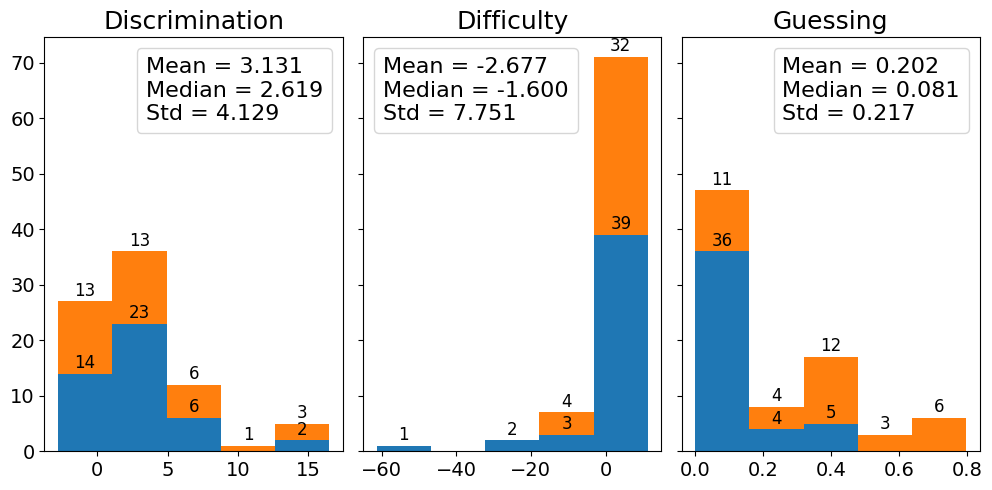

In [ ]:
output_dir = 'output'
output_dataset = output_dir+'/'+name_dataset
os.system("mkdir "+output_dataset+"/figures")

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10, 5))
n_bins = 5

item_param_text = {'Dis':'Discrimination','Dif':'Difficulty','Gues':'Guessing'}

minor_itens = []
major_itens = []
for c,i in enumerate(y_test):
  if i == 1:
    minor_itens.append(c)
  else:
    major_itens.append(c)

df_minor = item_param_df.iloc[minor_itens]
df_major = item_param_df.iloc[major_itens]

for c,item_p in enumerate(item_param_df):
  counts, edges, bars = axs[c].hist([df_major[item_p],df_minor[item_p]], bins=n_bins,histtype='barstacked', label="Mean = {:.3f}\nMedian = {:.3f}\nStd = {:.3f}".format(item_param_df[item_p].mean(),
                                                                                                              item_param_df[item_p].median(),
                                                                                                              item_param_df[item_p].std()))
  y_offset = 1
  for bar in axs[c].patches:
    if bar.get_height() != 0:
      axs[c].text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + bar.get_y() + y_offset,
          round(bar.get_height()),
          ha='center',
          color='black',
          size=12
      )

  axs[c].set_title(item_param_text[item_p])
  axs[c].title.set_size(18)
  axs[c].tick_params(labelsize=14)
  leg = axs[c].legend(loc='best', shadow=False, markerscale=0,handlelength=0, handletextpad=0, fancybox=True, fontsize=16)
  for item in leg.legendHandles:
      item.set_visible(False)

plt.show()
fig.savefig(output_dataset+'/figures/item_parameters_Hist.png', bbox_inches="tight", dpi=300)

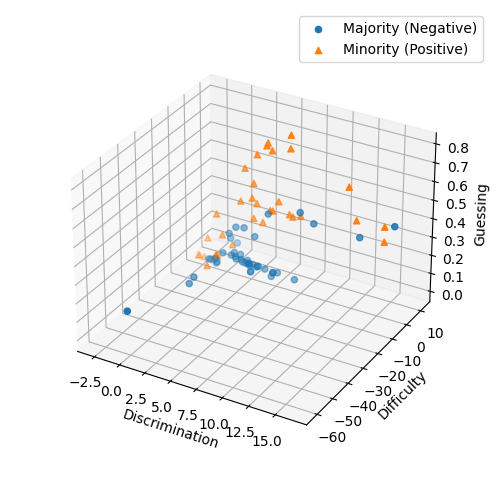

In [ ]:
output_dir = 'output'
output_dataset = output_dir+'/'+name_dataset

fig, ax = plt.subplots(subplot_kw={'projection': '3d'},gridspec_kw=dict(top=1, bottom=0, left=0, right=1))

minor_xs, minor_ys, minor_zs = [], [], []
major_xs, major_ys, major_zs = [], [], []

for c,i in enumerate(y_test):
  if i == 1:
    minor_xs.append(item_param_df['Dis'][c])
    minor_ys.append(item_param_df['Dif'][c])
    minor_zs.append(item_param_df['Gues'][c])
  else:
    major_xs.append(item_param_df['Dis'][c])
    major_ys.append(item_param_df['Dif'][c])
    major_zs.append(item_param_df['Gues'][c])

ax.scatter(major_xs, major_ys, major_zs, marker='o', label='Majority (Negative)')
ax.scatter(minor_xs, minor_ys, minor_zs, marker='^', label='Minority (Positive)')

ax.set_xlabel(item_param_text['Dis'])
ax.set_ylabel(item_param_text['Dif'])
ax.set_zlabel(item_param_text['Gues'])

ax.legend(loc='best', shadow=False)
ax.set_box_aspect(aspect=None, zoom=0.85)

fig.set_tight_layout(True)
fig.subplots_adjust(left=-1)
plt.show()
fig.savefig(output_dataset+'/figures/item_parameters_3D.png', bbox_inches="tight", dpi=300)

## Calculates classic metrics for fine-tuned models

In [ ]:
dict_ML_scores = calc_ML_metrics(dict_pred_final,y_test)

In [ ]:
df_ML_scores = pd.DataFrame(dict_ML_scores).transpose()
for col in df_ML_scores.columns:
  df_ML_scores[col] = df_ML_scores[col].apply(lambda x: round(x, 3))

In [ ]:
df_ML_scores

,acc_score,f1_score,precision_score,recall_score,mcc_score,auc_score,specf_score
RF,0.802,0.778,0.778,0.778,0.600,0.800,0.822
GB,0.827,0.781,0.893,0.694,0.656,0.814,0.933
BAG,0.790,0.761,0.771,0.750,0.574,0.786,0.822
ADA,0.765,0.725,0.758,0.694,0.523,0.758,0.822
KNN,0.617,0.523,0.586,0.472,0.213,0.603,0.733
DT,0.728,0.686,0.706,0.667,0.447,0.722,0.778
SVM,0.790,0.754,0.788,0.722,0.573,0.783,0.844
MLP,0.802,0.771,0.794,0.750,0.599,0.797,0.844
LDA,0.802,0.758,0.833,0.694,0.600,0.792,0.889
LSVM,0.790,0.773,0.744,0.806,0.580,0.792,0.778


### Create rankings with the results of the metrics

In [ ]:
df_ranking = df_ML_scores.copy()

for col in df_ranking:
  df_ranking[col] = df_ML_scores[col].rank(ascending=False, method='min')

In [ ]:
df_ranking.astype(int)

,acc_score,f1_score,precision_score,recall_score,mcc_score,auc_score,specf_score
RF,2,2,5,2,2,2,5
GB,1,1,1,6,1,1,1
BAG,5,5,6,3,6,6,5
ADA,8,8,7,6,8,8,5
KNN,10,10,10,10,10,10,10
DT,9,9,9,9,9,9,8
SVM,5,7,4,5,7,7,3
MLP,2,4,3,3,4,3,3
LDA,2,6,2,6,2,4,2
LSVM,5,3,8,1,5,4,8


Calculates the average variation of each model in the ranking

In [ ]:
for index, row in df_ranking.iterrows():
    print("{} : {:3.3f}   {:3.3f}".format(index,row.mean(),row.std()))

RF : 2.857   1.464
GB : 1.714   1.890
BAG : 5.143   1.069
ADA : 7.143   1.215
KNN : 10.000   0.000
DT : 8.857   0.378
SVM : 5.429   1.618
MLP : 3.143   0.690
LDA : 3.429   1.902
LSVM : 4.857   2.545


### Creates the ranking without instances with negative discrimination

In [ ]:
y_test_tmp = [y_test[i] for i in pos_dis_list]
dict_pred_tmp = {}
for clf in dict_pred_final:
  dict_pred_tmp[clf] = [dict_pred_final[clf][i] for i in pos_dis_list]

dict_ML_scores_tmp = calc_ML_metrics(dict_pred_tmp,y_test_tmp)

In [ ]:
df = pd.DataFrame(dict_ML_scores_tmp).transpose()
for col in df.columns:
  df[col] = df[col].apply(lambda x: round(x, 3))
df

,acc_score,f1_score,precision_score,recall_score,mcc_score,auc_score,specf_score
RF,0.951,0.941,0.923,0.96,0.899,0.952,0.944
GB,0.984,0.980,0.962,1.00,0.967,0.986,0.972
BAG,0.918,0.902,0.885,0.92,0.832,0.918,0.917
ADA,0.918,0.902,0.885,0.92,0.832,0.918,0.917
KNN,0.738,0.667,0.696,0.64,0.452,0.723,0.806
DT,0.869,0.846,0.815,0.88,0.734,0.871,0.861
SVM,1.000,1.000,1.000,1.00,1.000,1.000,1.000
MLP,0.967,0.962,0.926,1.00,0.935,0.972,0.944
LDA,1.000,1.000,1.000,1.00,1.000,1.000,1.000
LSVM,0.934,0.926,0.862,1.00,0.875,0.944,0.889


## Estimate the theta value of models

### Estimates the value of theta considering all instances

In [ ]:
irt_parameters_matrix = item_param_df.to_numpy()
col = np.ones((len(irt_parameters_matrix), 1))
irt_parameters_matrix = np.append(irt_parameters_matrix, col, axis = 1)

In [ ]:
dict_theta_all_instances = {}
batch_size = 2

dif_vector = [(c,i[0]) for c,i in enumerate(irt_parameters_matrix)]
dif_sort = sorted(dif_vector, key=lambda tup: tup[1])

qtd = len(dif_sort)//batch_size

for clf in dict_resp_final:

  adm_all_items = [i[0] for i in dif_sort]

  e_theta = dict_ML_scores[clf]['acc_score']

  r_vector_all = [True if dict_resp_final[clf][dif_i[0]] == 1 else False for dif_i in dif_sort]

  for p in range(1,batch_size+1):

    adm_items = adm_all_items[:qtd]
    adm_all_items = adm_all_items[qtd:]

    r_vector = r_vector_all[:qtd]
    r_vector_all = r_vector_all[qtd:]

    if p == batch_size:
      adm_items += adm_all_items
      r_vector += r_vector_all

    new_theta = NumericalSearchEstimator().estimate(items=irt_parameters_matrix,
                                                    administered_items= adm_items,
                                                    response_vector=r_vector,
                                                    est_theta=e_theta)
    e_theta = new_theta

  dict_theta_all_instances[clf] = new_theta

### Calculates the True Score of models

In [ ]:
dict_prob_correct = {}

for clf in dict_theta_all_instances:
  dict_prob_correct[clf] = list(icc_hpc(dict_theta_all_instances[clf],irt_parameters_matrix))

In [ ]:
for clf in dict_prob_correct:
  print('{} : {}'.format(clf,(100*sum(dict_prob_correct[clf]))/len(dict_prob_correct[clf])))

RF : 78.49003119860224
GB : 78.50714721904203
BAG : 78.52725538078113
ADA : 76.03374857717667
KNN : 66.9166178954935
DT : 76.58677908629437
SVM : 77.89613848073323
MLP : 76.512326953522
LDA : 78.39810087947858
LSVM : 76.512326953522


### Calculates the Total Score of the models

In [ ]:
dict_totalScore = {}

for clf in dict_prob_correct:
  dict_totalScore[clf] = calc_irt_totalScore(dict_resp_final[clf], dict_prob_correct[clf])

In [ ]:
for clf in dict_prob_correct:
  print('{} : {}'.format(clf,(100*dict_totalScore[clf])/len(dict_prob_correct[clf])))

RF : 58.73694477884918
GB : 61.223196601758055
BAG : 57.53960105979346
ADA : 52.576958453719875
KNN : 28.64501295722188
DT : 49.42628525913389
SVM : 56.90848415974558
MLP : 56.759240533768946
LDA : 58.64501445972547
LSVM : 55.52467263253437


#### Correlacao entre as metricas

In [ ]:
tmp_dict = copy.deepcopy(dict_ML_scores)

for clf in dict_prob_correct:
  tmp_dict[clf]['TrueScore'] = (sum(dict_prob_correct[clf]))/len(dict_prob_correct[clf])
  tmp_dict[clf]['TotalScore'] = (dict_totalScore[clf])/len(dict_prob_correct[clf])

In [ ]:
df = pd.DataFrame(tmp_dict).transpose()
df = df.drop(columns=['mcc_score'])
#df = df.drop(columns=['specf_score'])
corr = df.corr()

In [ ]:
df[['TrueScore','TotalScore']].apply(lambda x: round(x, 4))

,TrueScore,TotalScore
RF,0.7849,0.5874
GB,0.7851,0.6122
BAG,0.7853,0.5754
ADA,0.7603,0.5258
KNN,0.6692,0.2865
DT,0.7659,0.4943
SVM,0.7790,0.5691
MLP,0.7651,0.5676
LDA,0.7840,0.5865
LSVM,0.7651,0.5552


In [ ]:
df[['TrueScore','TotalScore']].rank(ascending=False, method='min').astype(int)

,TrueScore,TotalScore
RF,3,2
GB,2,1
BAG,1,4
ADA,9,8
KNN,10,10
DT,6,9
SVM,5,5
MLP,7,6
LDA,4,3
LSVM,7,7


In [ ]:
0.6122 - 0.5874

0.024799999999999933

In [ ]:
corr.style.background_gradient(cmap='coolwarm')

,acc_score,f1_score,precision_score,recall_score,auc_score,specf_score,TrueScore,TotalScore
acc_score,1.000000,0.988715,0.933388,0.872052,0.997410,0.778298,0.936606,0.991455
f1_score,0.988715,1.000000,0.871585,0.934349,0.996756,0.676964,0.943311,0.986698
precision_score,0.933388,0.871585,1.000000,0.640777,0.905519,0.948644,0.855651,0.918501
recall_score,0.872052,0.934349,0.640777,1.000000,0.904995,0.371416,0.850888,0.877303
auc_score,0.997410,0.996756,0.905519,0.904995,1.000000,0.731121,0.939194,0.990754
specf_score,0.778298,0.676964,0.948644,0.371416,0.731121,1.000000,0.685185,0.755351
TrueScore,0.936606,0.943311,0.855651,0.850888,0.939194,0.685185,1.000000,0.974309
TotalScore,0.991455,0.986698,0.918501,0.877303,0.990754,0.755351,0.974309,1.000000


In [ ]:
from scipy import stats

stats.friedmanchisquare(df["acc_score"],df["f1_score"],df["precision_score"],
                        df["recall_score"],df["auc_score"],df["specf_score"],
                        df["TrueScore"],df["TotalScore"])

FriedmanchisquareResult(statistic=54.459330143540654, pvalue=1.9077754180198624e-09)

In [ ]:
!pip install scikit-posthocs

In [ ]:
import scikit_posthocs as sp
# Combine three groups into one array
#df.rename(columns={'acc_score': 'acc','f1_score': 'f1','f1_score': 'f1','precision_score': 'precision','auc_score': 'auc','specf_score': 'specf'}, inplace=True)

# Conduct the Nemenyi post-hoc test
df_nemenyi = sp.posthoc_nemenyi_friedman(df)

In [ ]:
df_nemenyi.style.background_gradient(cmap='coolwarm')

,acc_score,f1_score,precision_score,recall_score,auc_score,specf_score,TrueScore,TotalScore
acc_score,1.000000,0.052791,0.642482,0.012247,0.900000,0.900000,0.751638,0.001000
f1_score,0.052791,1.000000,0.900000,0.900000,0.417645,0.001041,0.806216,0.477509
precision_score,0.642482,0.900000,1.000000,0.642482,0.900000,0.087503,0.900000,0.022670
recall_score,0.012247,0.900000,0.642482,1.000000,0.172514,0.001000,0.533327,0.751638
auc_score,0.900000,0.417645,0.900000,0.172514,1.000000,0.477509,0.900000,0.001041
specf_score,0.900000,0.001041,0.087503,0.001000,0.477509,1.000000,0.138889,0.001000
TrueScore,0.751638,0.806216,0.900000,0.533327,0.900000,0.138889,1.000000,0.012247
TotalScore,0.001000,0.477509,0.022670,0.751638,0.001041,0.001000,0.012247,1.000000


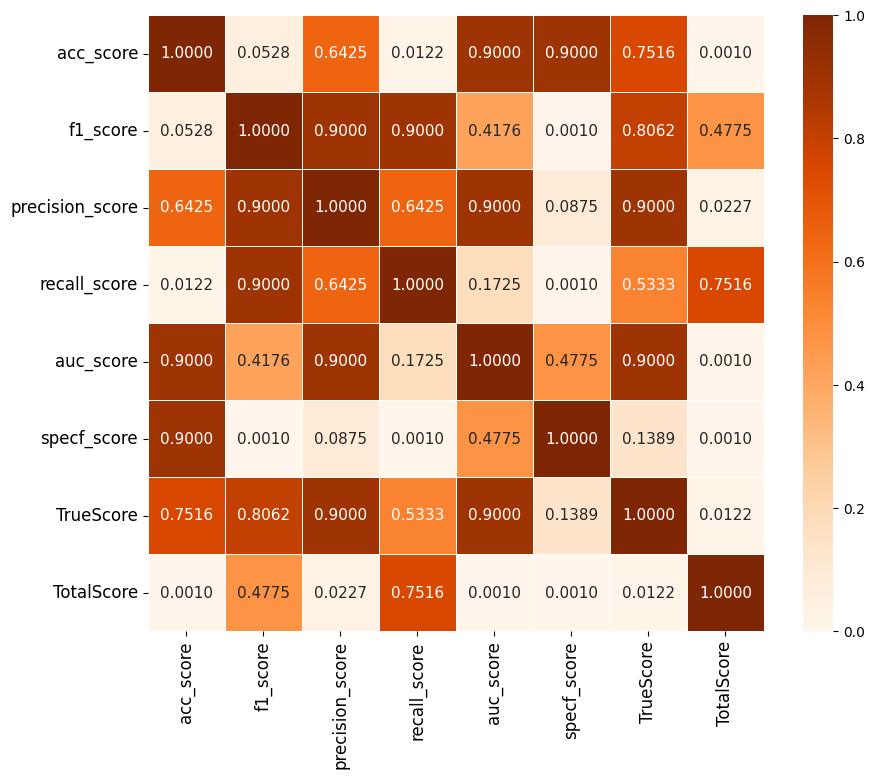

In [ ]:
output_dir = 'output'
output_dataset = output_dir+'/'+name_dataset
os.system("mkdir "+output_dataset+"/figures")

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_nemenyi,
    cmap="Oranges",
    vmin=0, vmax=1.0,
    square=True, ax=ax,
            annot=True,
            fmt=".4f",
            linewidth=.5,
            annot_kws={"fontsize":11})
ax.tick_params(labelsize=12)
f.savefig(output_dataset+'/figures/metrics_heatmap.png',bbox_inches="tight", dpi=300)

In [ ]:
print('Mean')
for col in corr:
  print("{}: {}".format(col,corr[col].mean()))

Mean
acc_score: 0.9441937758875198
f1_score: 0.9319261722010551
precision_score: 0.8897002730025803
recall_score: 0.8138867887339535
mcc_score: 0.9440076458707567
auc_score: 0.9403522975204253
specf_score: 0.7470512210336969
TrueScore: 0.9023358055166513
TotalScore: 0.9428267883086172


<Axes: >

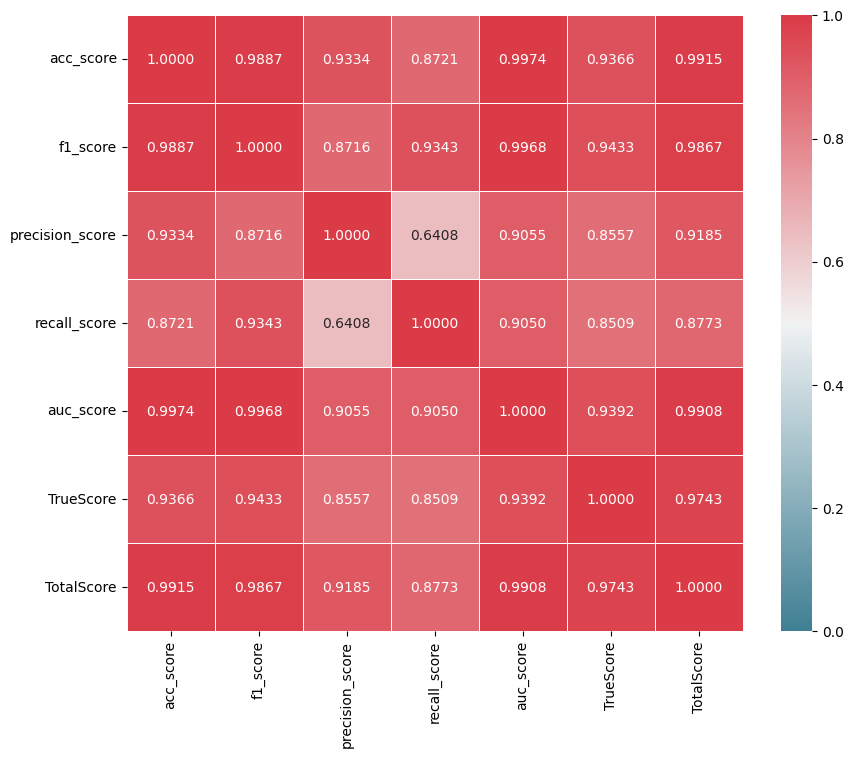

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=0, vmax=1.0,
    square=True, ax=ax,
            annot=True,
            fmt=".4f",
            linewidth=.5)

##

#### Correlacao entre as metricas (percentual)

In [ ]:
tmp_dict = copy.deepcopy(dict_ML_scores)

for clf in dict_prob_correct:
  tmp_dict[clf]['irt_prob_correct'] = (100*sum(dict_prob_correct[clf]))/len(dict_prob_correct[clf])
  tmp_dict[clf]['irt_totalScore'] = (100*dict_totalScore[clf])/len(dict_prob_correct[clf])

In [ ]:
df = pd.DataFrame(tmp_dict).transpose()
corr = df.corr()

<Axes: >

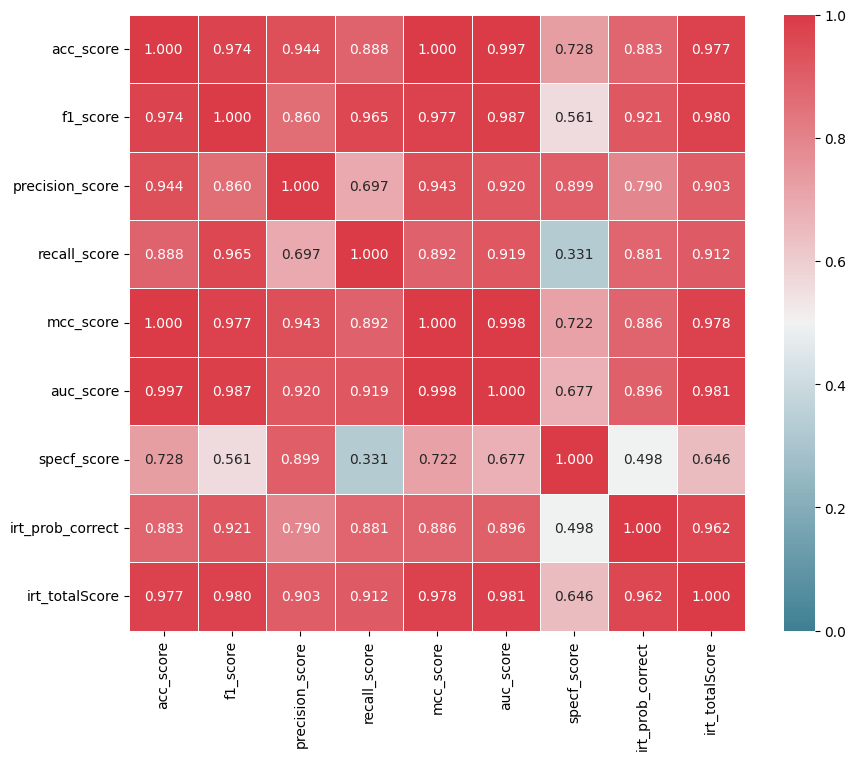

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=0, vmax=1.0,
    square=True, ax=ax,
            annot=True,
            fmt=".3f",
            linewidth=.5)

## Separate the instances by the confusion matrix

In [ ]:
dict_irt_confusion_matrix = {}

cm_list = {'tp':0, 'fp':1, 'tn':2, 'fn':3}

param_list = {'Dis':0, 'Dif':1, 'Gues':2}

for clf in dict_resp_final:

  cm_instances = list_confusion_matrix(y_test,dict_pred_final[clf])

  dict_irt_confusion_matrix[clf] = {}

  for instance_type in cm_list:

    irt_matrix_tmp = np.array([irt_parameters_matrix[i] for i in cm_instances[cm_list[instance_type]]])

    dict_irt_confusion_matrix[clf][instance_type] = {}

    for param in param_list:

      param_tmp = [i[param_list[param]] for i in irt_matrix_tmp]

      dict_irt_confusion_matrix[clf][instance_type][param] = param_tmp

### Calculates the True Score and Total Score for instances separated into TP, TN, FP and FN

In [ ]:
dict_prob_correct_confusion_matrix = {}
dict_totalScore_confusion_matrix = {}
dict_percIRT_confusion_matrix = {}
dict_Mean_probCorrect_confusion_matrix = {}

cm_list = {'tp':0, 'fp':1, 'tn':2, 'fn':3}

for clf in dict_theta_all_instances:

  cm_instances = list_confusion_matrix(y_test,dict_pred_final[clf])

  dict_prob_correct_confusion_matrix[clf] = {}
  dict_totalScore_confusion_matrix[clf] = {}
  dict_percIRT_confusion_matrix[clf] = {}
  dict_Mean_probCorrect_confusion_matrix[clf] = {}

  for instance_type in cm_list:

    irt_matrix_tmp = np.array([irt_parameters_matrix[i] for i in cm_instances[cm_list[instance_type]]])
    resp_list_tmp = [dict_resp_final[clf][i] for i in cm_instances[cm_list[instance_type]]]

    prob_correct_tmp = list(icc_hpc(dict_theta_all_instances[clf],irt_matrix_tmp))

    sum_pc = sum(prob_correct_tmp)
    prob_perc_sum = (100*sum_pc)/len(resp_list_tmp)

    totalScore_tmp = calc_irt_totalScore(resp_list_tmp,prob_correct_tmp)
    prob_irt_mean = ((min(prob_correct_tmp) + max(prob_correct_tmp)) / 2) * len(resp_list_tmp)

    dict_prob_correct_confusion_matrix[clf][instance_type] = prob_correct_tmp
    dict_totalScore_confusion_matrix[clf][instance_type] = totalScore_tmp
    dict_percIRT_confusion_matrix[clf][instance_type] = prob_perc_sum
    dict_Mean_probCorrect_confusion_matrix[clf][instance_type] = prob_irt_mean

### Item Characteristic Confusion Matrix Curve (ICCMC)

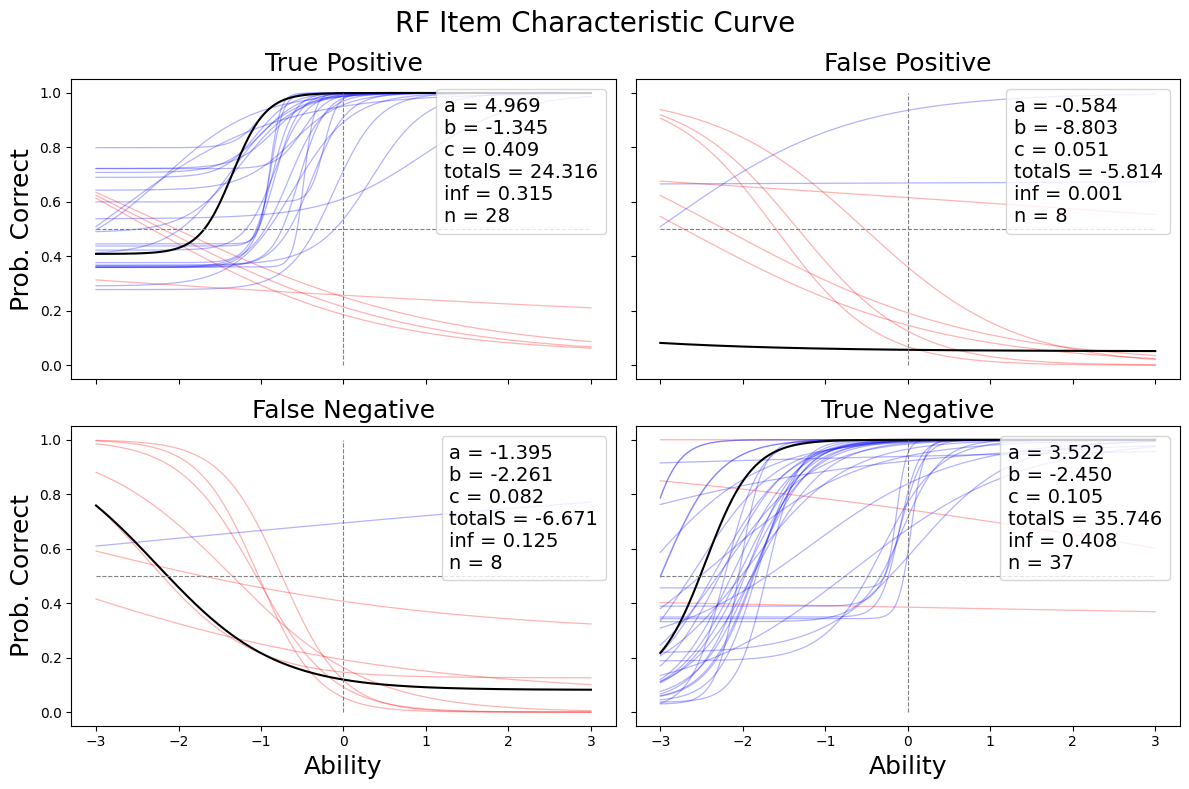

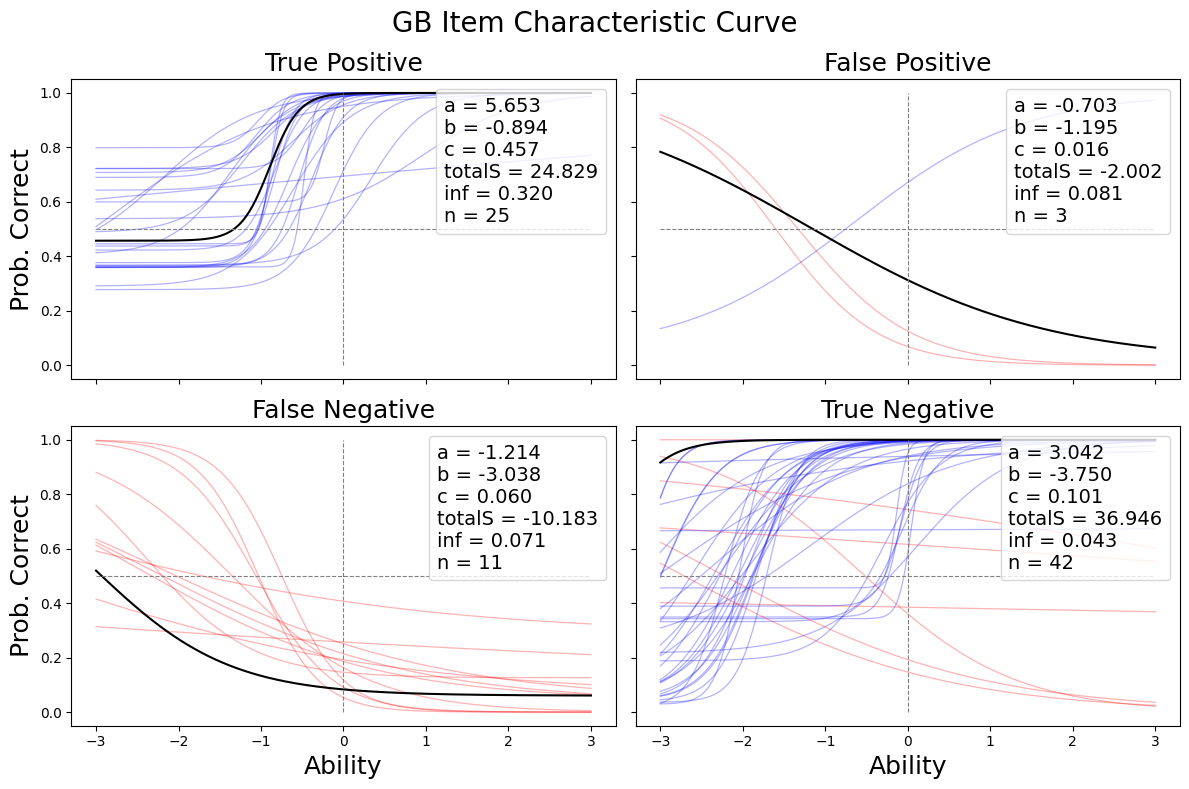

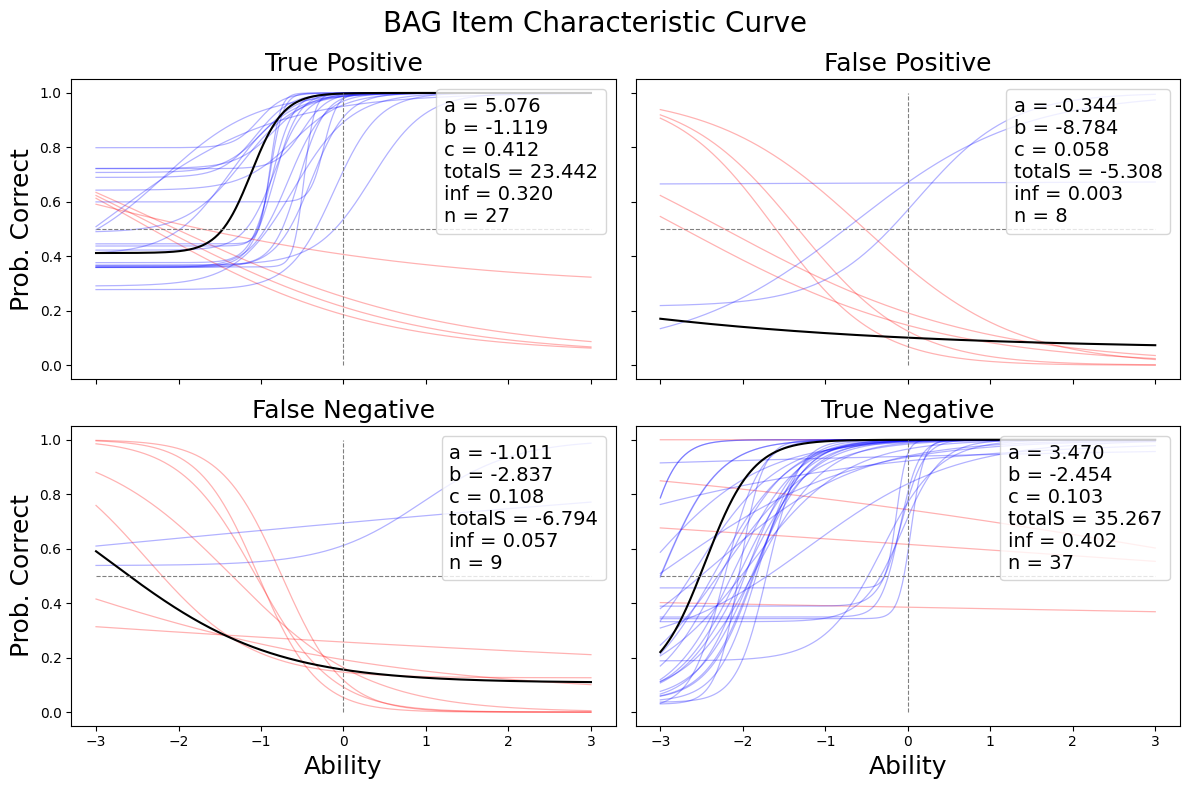

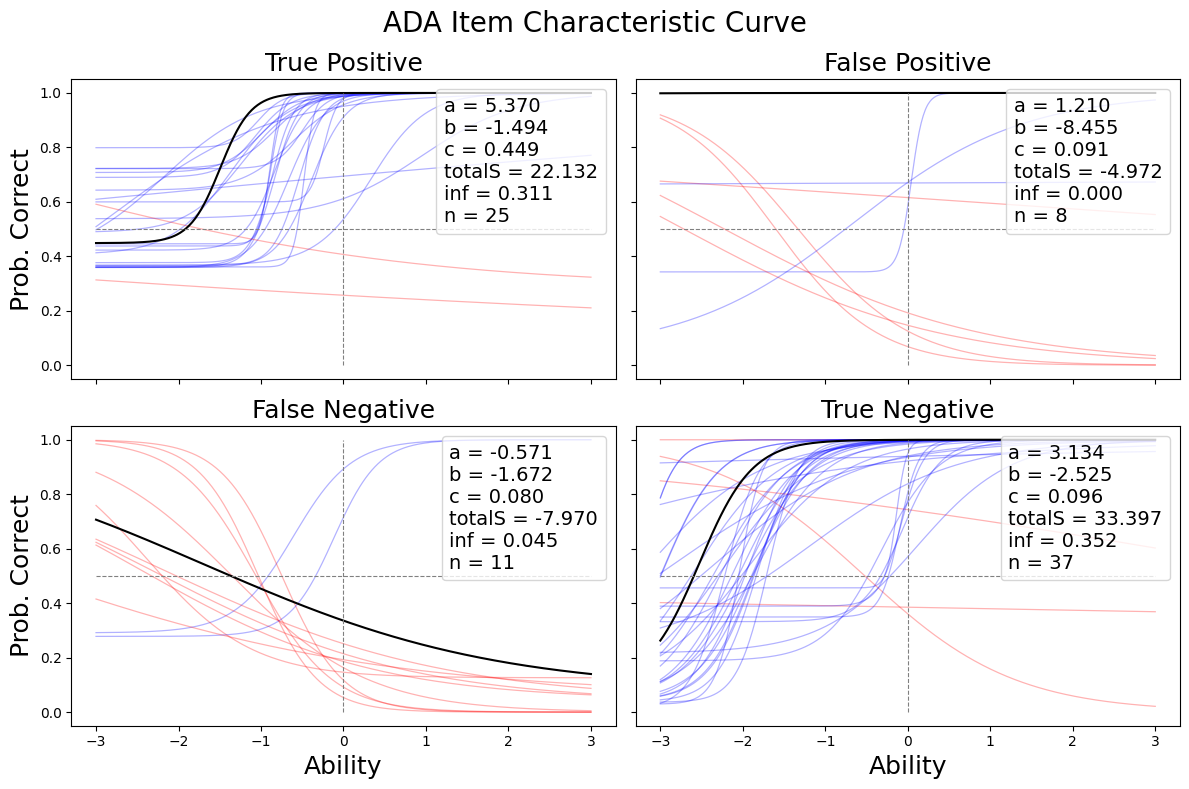

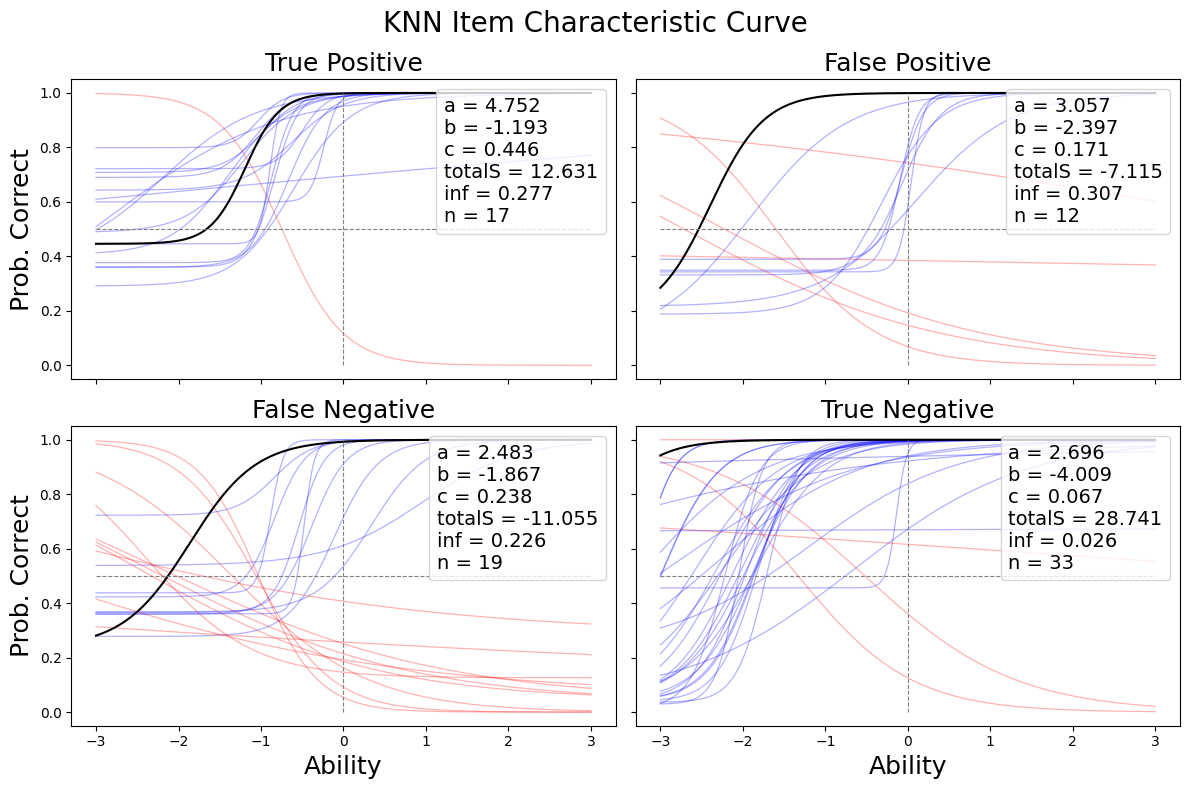

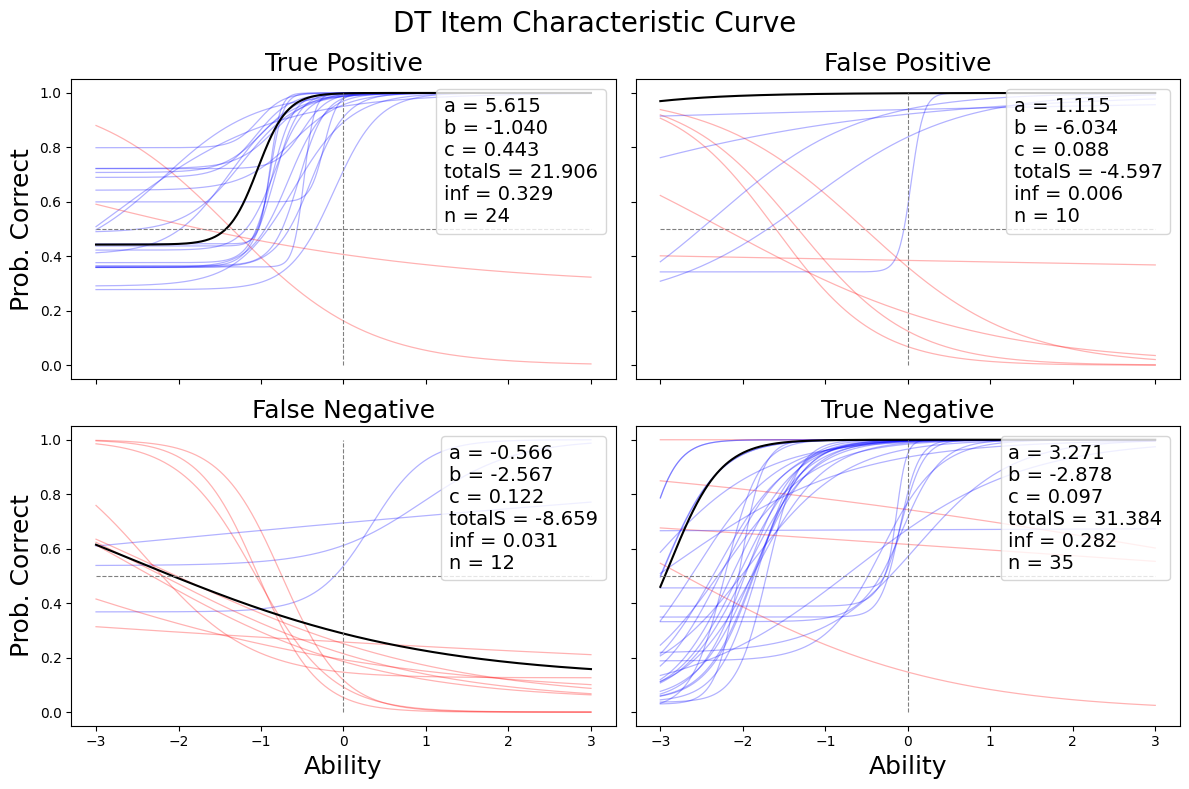

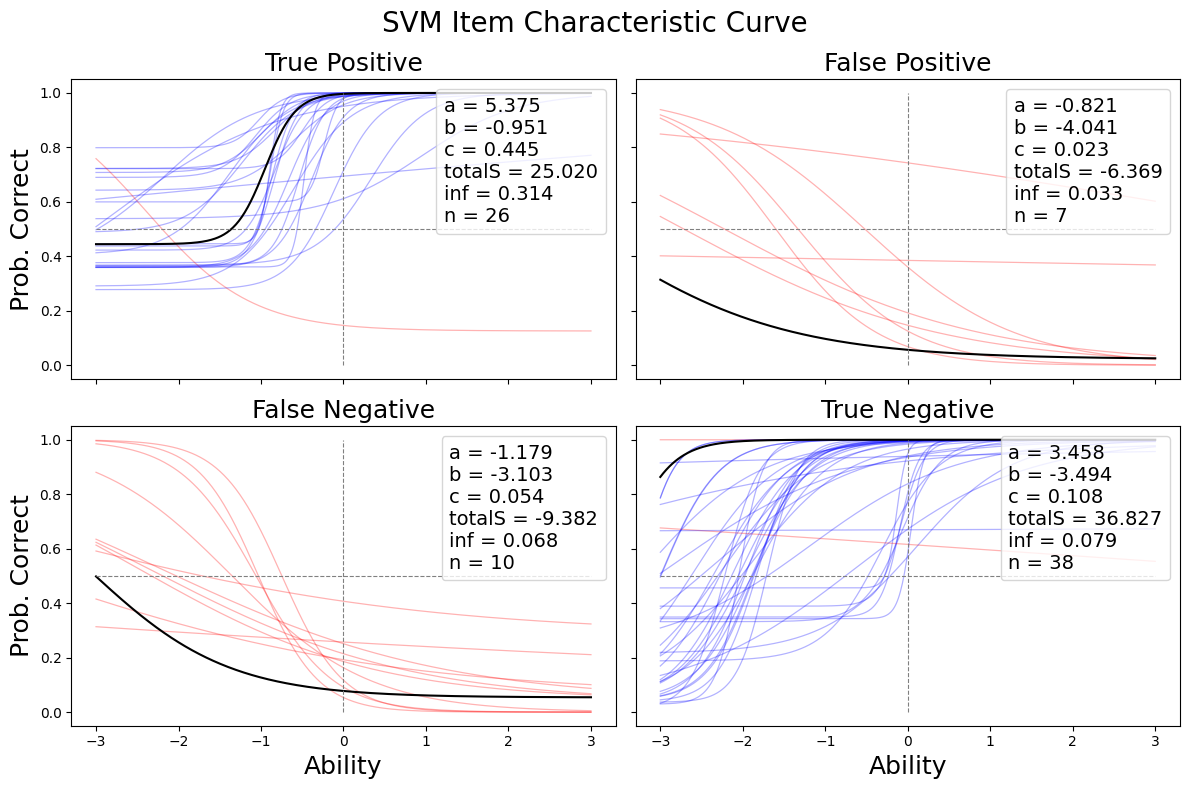

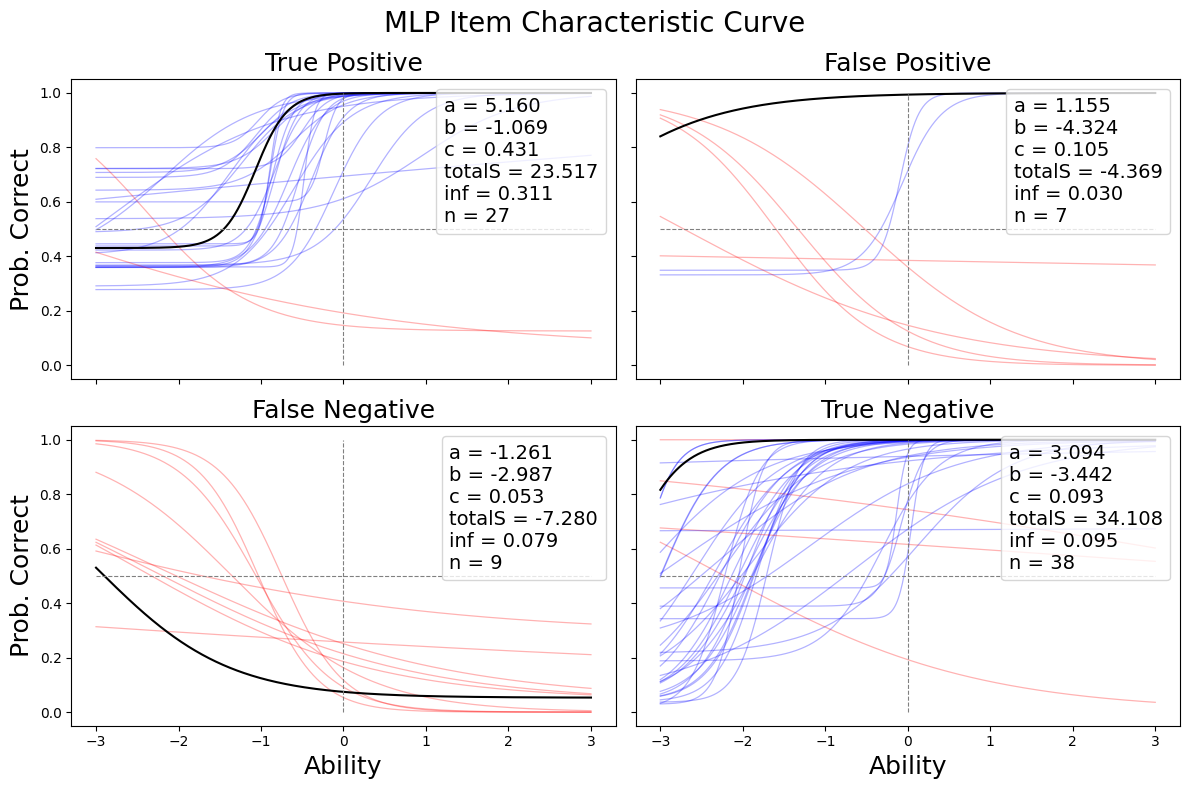

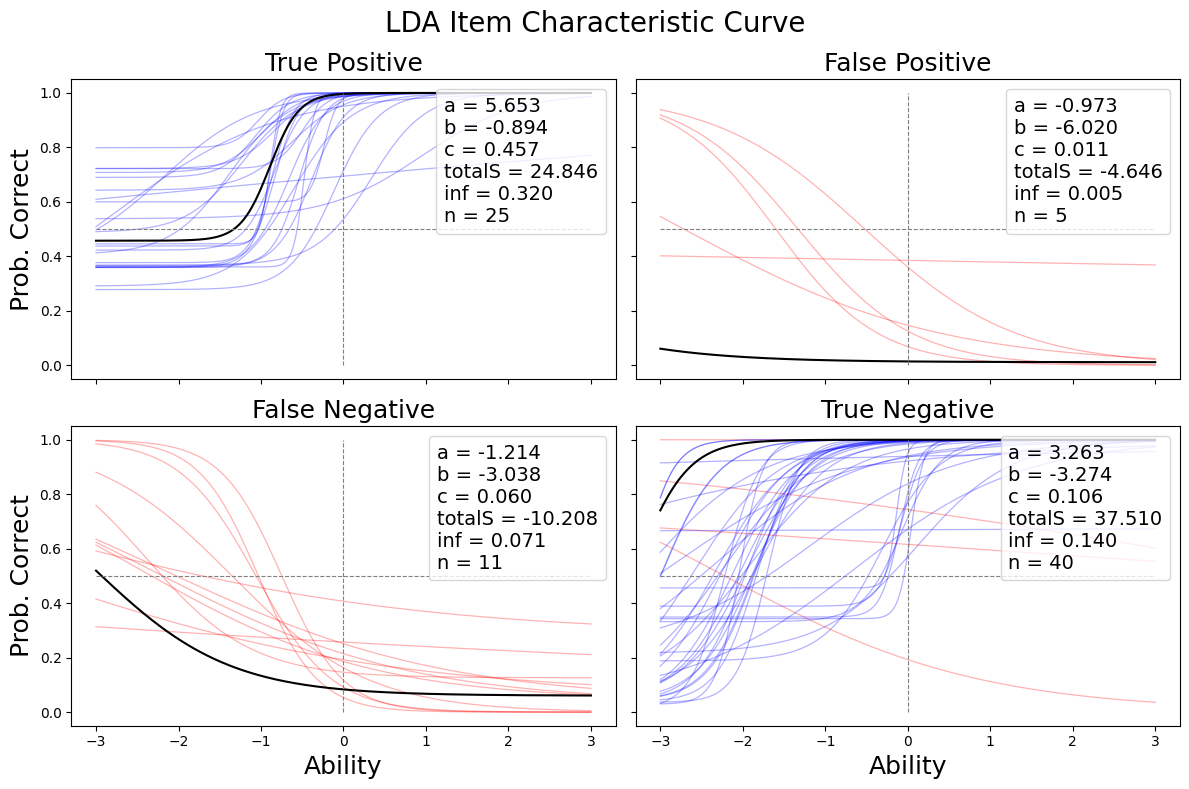

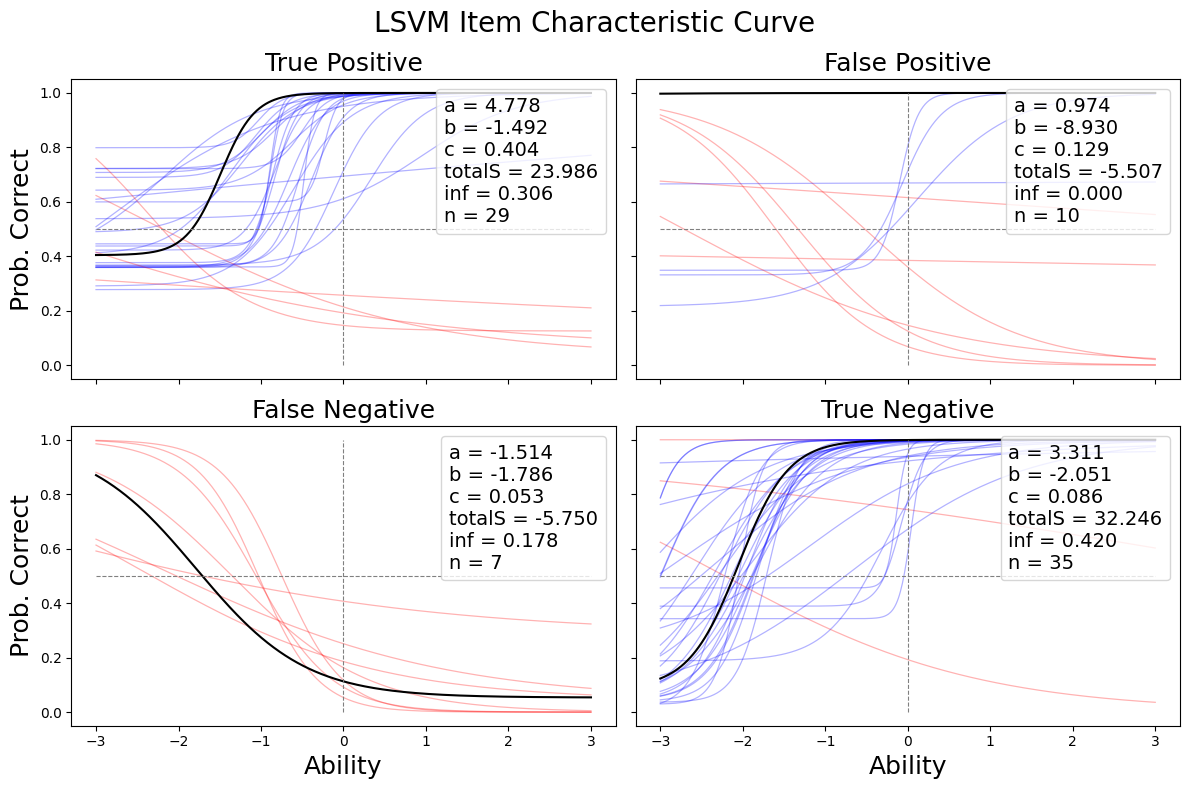

In [ ]:
output_dir = 'output'
output_dataset = output_dir+'/'+name_dataset
os.system("mkdir "+output_dataset+"/figures")

for clf in dict_theta_all_instances:

  cm_instances = list_confusion_matrix(y_test,dict_pred_final[clf])

  plot_icc(irt_parameters_matrix,cm_instances,clf,output_dataset,dict_prob_correct_confusion_matrix,dict_totalScore_confusion_matrix)